# Planning Agents with LangGraph and Together AI

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Tools_and_Integrations/Agent_Frameworks/LangGraph/LangGraph_Planning_Agent.ipynb)

<img src="../../../images/langgraph.png" width="700">

This notebook demonstrates how to create an intelligent planning agent that can:
1. Break down complex queries into smaller, manageable steps
2. Execute each step sequentially
3. Adapt its plan based on new information
4. Provide coherent final answers

## Setup and Imports

In [1]:
# Install required packages
!pip install -qU langchain-together langchain-community tavily-python langgraph

We initialize the LLM using Together AI's Llama model. This will be our core reasoning engine

In [2]:
# Setting up the Language Model

import os
from langchain_together import ChatTogether

llm = ChatTogether(model="meta-llama/Llama-3.3-70B-Instruct-Turbo", api_key=os.environ.get("TOGETHER_API_KEY"))

We set up the Tavily search tool to allow our agent to find information online

In [3]:
# Set up search tool using Tavily
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3, tavily_api_key=os.environ.get("TAVILY_API_KEY"))]

## Setup a ReAct Agent

We create a ReAct agent that can use tools and reason about their outputs

In [4]:
from langchain import hub

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

## Defining the Planning Structure

We create type definitions to manage the planning state

In [5]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

# Define types for the planning system
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [6]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

## Setting up the Planner

The planner is responsible for breaking down complex queries into steps

In [7]:
# Set up the planner
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | ChatTogether(model="meta-llama/Llama-3.3-70B-Instruct-Turbo").with_structured_output(Plan)

In [8]:
final_state = planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

In [9]:
final_state

Plan(steps=["Find the current year's Australia Open winner", 'Find the hometown of the winner'])

## Defining Core Functions

Three main functions drive the planning process:

1. `execute_step`: Executes a single step of the plan using the agent
2. `plan_step`: Creates the initial plan from the user's query
3. `replan_step`: Revises the plan based on execution results

In [10]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatTogether(model="meta-llama/Llama-3.3-70B-Instruct-Turbo", temperature=0).with_structured_output(Act)

In [11]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

## Building the Workflow Graph

We create a directed graph that coordinates the planning and execution

In [12]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

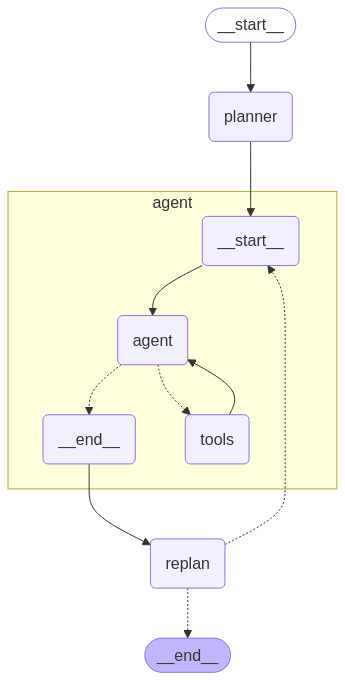

In [13]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Example Usage

Let's see how the agent handles a real query!

In [14]:
config = {"recursion_limit": 25}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}
try:
    async for event in app.astream(inputs, config=config):
        for k, v in event.items():
            if k != "__end__":
                print(v)
except IndexError as e:
    print(f"Error: {e}. The plan list is empty or index is out of range.")
    print("Execution terminated.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Execution terminated.")

{'plan': ["Find the winner of the men's 2024 Australia Open", 'Determine the hometown of the winner']}
{'past_steps': [("Find the winner of the men's 2024 Australia Open", "The winner of the men's 2024 Australia Open is Jannik Sinner. \n\nSource: \nhttps://ausopen.com/articles/news/sinner-winner-italian-takes-first-major-ao-2024 \nhttps://www.youtube.com/watch?v=qvY9Jl7CI7U\nhttps://en.wikipedia.org/wiki/2024_Australian_Open \n\nPlease let me know when to proceed with the next step to determine the hometown of the winner.")]}
{'plan': ['Determine the hometown of Jannik Sinner']}
{'past_steps': [('Determine the hometown of Jannik Sinner', "Jannik Sinner's hometown is Sexten in the Dolomites, Northern Italy.")]}
{'plan': []}
Error: list index out of range. The plan list is empty or index is out of range.
Execution terminated.


This demonstrates how complex queries can be broken down and executed systematically, with the agent adapting its plan as new information becomes available.

## Visual Workflow
The graph visualization shows how information flows through the system:
- Start → Planner: Creates initial plan
- Planner → Agent: Executes steps
- Agent → Replan: Updates plan based on new information
- Replan → Either back to Agent or to End

This creates a flexible system that can handle complex, multi-step queries while maintaining context and adapting to new information.